In [1]:
# Jupyter Notebook for analysis of intan recording files


In [2]:
# Install some extra requirements
#!pip install -r requirements.txt
#!pip install PyWavelets seaborn==0.13.2

In [1]:
import os
import sys

# Mount G drive 
g_drive_path = 'G:\\'  # For Windows

# Check if the G drive is accessible
if not os.path.exists(g_drive_path):
    print(f"Error: G drive not found at {g_drive_path}. Please check the drive letter.")
else:
    print(f"G drive found at {g_drive_path}.")
    
# Add the parent directory of utilities to sys.path
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)


G drive found at G:\.


In [2]:
# Initialize IntanPython
import intan
print(intan.__version__)
ipy = intan.IntanPython()

0.0.2


In [29]:
# Define paths and folder names
#data_dir = os.path.join(g_drive_path, "Shared drives", "NML_shared", "DataShare", "HDEMG_SCI", "MCP01_NML-EMG", "2024_12_10")
data_dir = os.path.join(g_drive_path, "Shared drives", "NML_shared", "DataShare", "HDEMG_SCI", "MCP01_NML-EMG", "2024_11_12")
abduct = [
    'abduct_p1_0_241210_172524',
    'abduct_p1_1_241210_172539',
    'abduct_p1_2_241210_172551',
    'abduct_p1_3_241210_172710',
    'abduct_p1_4_241210_172722',
]
adduct = [
    'adduct_p1_0_241210_172528',
    'adduct_p1_1_241210_172606',
    'adduct_p1_2_241210_172632',
    'adduct_p1_3_241210_172726',
    'adduct_p1_4_241210_172752'
]
extend = [
    'extend_p1_0_241210_172602',
    'extend_p1_1_241210_172610',
    'extend_p1_2_241210_172659',
    'extend_p1_3_241210_172733',
    'extend_p1_4_241210_172807'
]
wflex = [
    'wflex_p1_0_241210_172517',
    'wflex_p1_1_241210_172536',
    'wflex_p1_2_241210_172543',
    'wflex_p1_3_241210_172811',
    'wflex_p1_4_241210_172818',
]
wextend = [
    'wextend_p1_0_241210_172513',
    'wextend_p1_1_241210_172617',
    'wextend_p1_2_241210_172651',
    'wextend_p1_3_241210_172703',
    'wextend_p1_4_241210_172729'
]
tripod = [
    'tripod_p1_0_241210_172621',
    'tripod_p1_1_241210_172629',
    'tripod_p1_2_241210_172636',
    'tripod_p1_3_241210_172640',
    'tripod_p1_4_241210_172744'
]
supinate = [
    'supinate_p1_0_241210_172555',
    'supinate_p1_1_241210_172655',
    'supinate_p1_2_241210_172741',
    'supinate_p1_3_241210_172748',
    'supinate_p1_4_241210_172803'
]
pronate = [
    'pronate_p1_0_241210_172520',
    'pronate_p1_1_241210_172644',
    'pronate_p1_2_241210_172707',
    'pronate_p1_3_241210_172714',
    'pronate_p1_4_241210_172718',
]
rest = [
    'rest_p1_1_241210_172532',
    'rest_p1_2_241210_172558',
    'rest_p1_3_241210_172737',
    'rest_p1_4_241210_172800',
    'rest_p1_5_241210_172815'
]
grip = [
    'grip_p1_1_241210_172547',
    'grip_p1_2_241210_172613',
    'grip_p1_3_241210_172625',
    'grip_p1_4_241210_172648',
    'grip_p1_5_241210_172756'
]



In [24]:
import numpy as np
from scipy.signal import butter, filtfilt

# Define the bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4, axis=1):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, data, axis=axis)

In [28]:
# Process each file



# Storage for trimmed EMG data from all files
all_trimmed_data = []
for folder in folders:

    file_name = f"{folder}.rhd" # Define file paths
    file_path = os.path.join(data_dir, folder, file_name)

    # Load intan data
    ipy.load_file(file_path)
    t_data, emg_data = ipy.get_waveform_data() # EMG data
    t_dig, data_dig = ipy.get_dig_in_data()    # Digital sync data

    # Filter sEMG data
    filtered_data = butter_bandpass_filter(emg_data, 30, 500, 4000, 10)

    # Find events (start/stop sync signal changes)
    if len(data_dig) == 0:
        print("No digital sync events")
        events_idx = [0,filtered_data.shape[1]]
    else:
        events_idx = np.where(np.diff(data_dig[0]))[0]  # Indices where digital signal flips
        if len(events_idx ) < 2:
            print(f"Skipping file {file_name}: Less that two sync events found")

    # Trim EMG data between the first start and stop events
    trimmed_emg_data = filtered_data[:, events_idx[0]:events_idx[1]]
    all_trimmed_data.append(trimmed_emg_data)

# Convert to numpy array for easier averaging
# Ensure all trimmed data has the same shape
min_samples = min(data.shape[1] for data in all_trimmed_data)
aligned_data = [data[:, :min_samples] for data in all_trimmed_data]
all_trimmed_data = np.array(aligned_data)  # Shape: (num_files, num_channels, num_samples)


|  Loading data from G:\Shared drives\NML_shared\DataShare\HDEMG_SCI\MCP01_NML-EMG\2024_11_12\wrist_extension_241112_170408\wrist_extension_241112_170408.rhd

Reading Intan Technologies RHD Data File, Version 3.3

File contains 33.600 seconds of data.  Amplifiers were sampled at 4.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 1.6 seconds
No digital sync events


In [26]:
import matplotlib.pyplot as plt

def plot_data(time_vector, data, title=''):
     plt.figure()
     plt.plot(time_vector, data)
     plt.title(title)
     plt.xlabel("Time (s)")
     plt.ylabel("uV")
     plt.show()

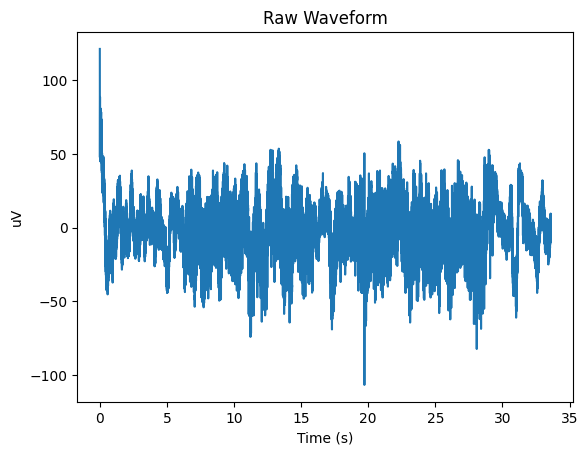

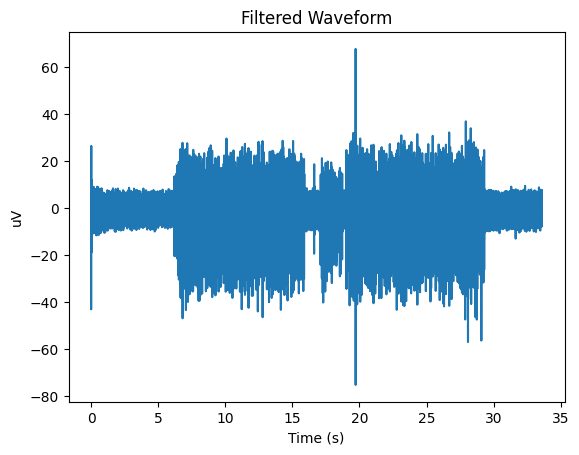

In [27]:
# Compare the raw and filtered data

t_data, emg_data = ipy.get_waveform_data() # EMG data
plot_data(t_data, emg_data[0], 'Raw Waveform')

n_channels, n_samples = all_trimmed_data[0].shape
t_avg = np.linspace(0, n_samples/4000, n_samples)

plot_data(t_avg, all_trimmed_data[0][0], 'Filtered Waveform')



In [7]:
print(all_trimmed_data.shape)

# Plot the filtered data

# Calculate the waveform average across all files for each channel
#waveform_average = np.mean(all_trimmed_data, axis=0)  # Shape: (num_channels, num_samples)
#print("Waveform average shape:", waveform_average.shape)
        

(5, 128, 8664)


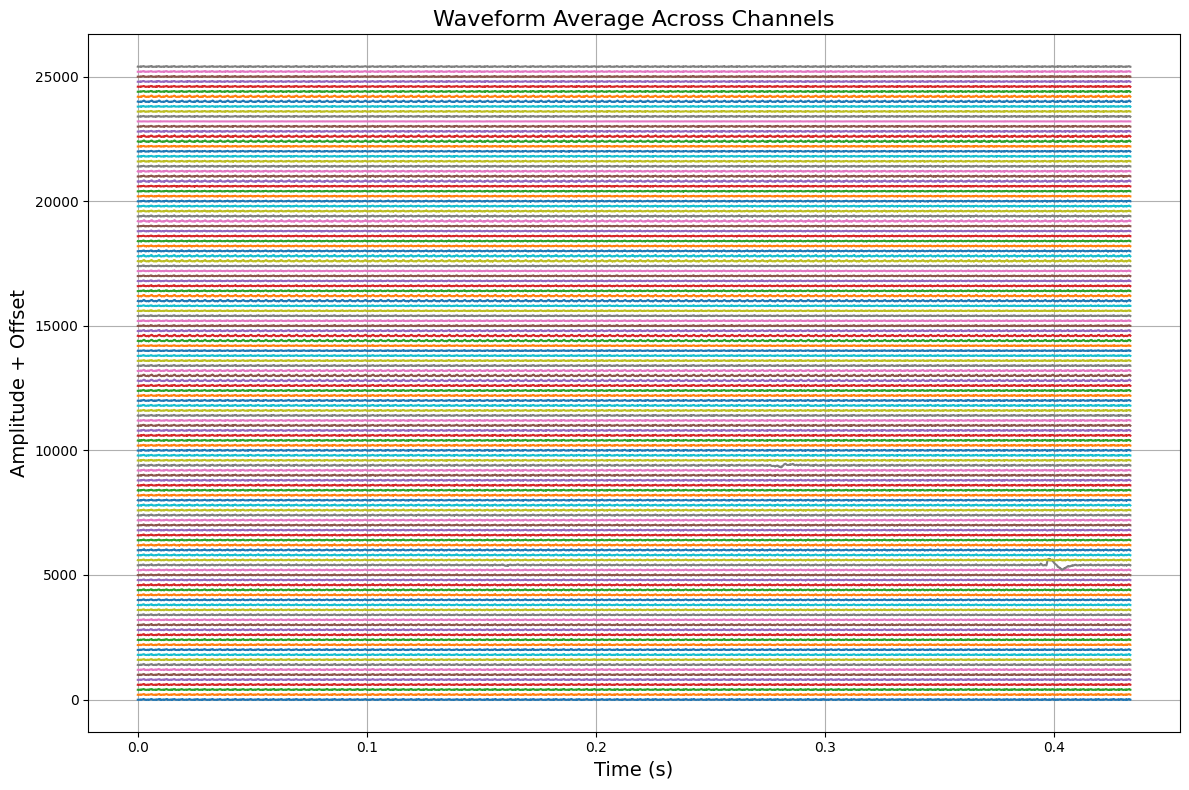

In [40]:
# Visualize waterfall plot (currently not working in jupyter notebook)
#ipy.waterfall_plot(t_data, emg_data, [0], downsampling_factor=2)

# Can still do simple plot
# import matplotlib.pyplot as plt

# def plot_data(time_vector, data, title=''):
#     plt.figure()
#     plt.plot(time_vector, data)
#     plt.title("Amplifier Time Vector")
#     plt.xlabel("Time (s)")
#     plt.ylabel("uV")
#     plt.show()

# plot_data(t_data, emg_data[13])
# plot_data(t_data, emg_data[15])
# plot_data(t_dig, data_dig[0])
# Assuming waveform_average has shape (num_channels, num_samples)
num_channels, num_samples = waveform_average.shape
time_vector = np.linspace(0, num_samples / 20000, num_samples)  # Adjust sampling rate (e.g., 20kHz) as needed

# Create a figure
plt.figure(figsize=(12, 8))

# Plot each channel
offset = 0  # For offsetting the waveforms
offset_increment = 200  # Adjust based on signal amplitude for clear visualization

for i in range(num_channels):
    plt.plot(time_vector, waveform_average[i, :] + offset, label=f"Channel {i+1}")
    offset += offset_increment  # Add offset for next channel

# Add labels, title, and legend
plt.title("Waveform Average Across Channels", fontsize=16)
plt.xlabel("Time (s)", fontsize=14)
plt.ylabel("Amplitude + Offset", fontsize=14)
#plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.05), fontsize=10, ncol=2)
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()
